In [ ]:
#%pip install -q -r requirements.txt

# Анализ бизнес-показателей

### Описание проекта
Несколько прошлых месяцев наш бизнес, развлекательное приложение Procrastinate Pro+, постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Нам нужно разобраться в причинах этой ситуации.\
У нас в распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Нам предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.

### Описание данных
Таблица **visits_log_short** (лог сервера с информацией о посещениях сайта):

- `User Id` — уникальный идентификатор пользователя
- `Device` — категория устройства пользователя
- `Session start` — дата и время начала сессии
- `Session End` — дата и время окончания сессии
- `Channel` — идентификатор рекламного источника, из которого пришел пользователь
- `Region` - страна пользователя

Таблица **orders_log_short** (информация о заказах):

- `User Id` — уникальный id пользователя, который сделал заказ
- `Event Dt` — дата и время покупки
- `Revenue` — выручка

Таблица **costs_short** (информация о затратах на маркетинг):

- `Channe` — идентификатор рекламного источника
- `Dt` — дата
- `Costs` — затраты на этот рекламный источник в этот день

### Содержание
- <a id="Загрузка-данных-и-подготовка-их-к-анализу"></a>[1. Загрузка данных и подготовка их к анализу](#1.-Загрузка-данных-и-подготовка-их-к-анализу)
- <a id="Функции-для-расчета-и-анализа-LTV,-ROI,-удержания-и-конверсии"></a>[2. Функции для расчета и анализа LTV, ROI, удержания и конверсии](#2.-Функции-для-расчета-и-анализа-LTV,-ROI,-удержания-и-конверсии)
- <a id="Исследовательский-анализ-данных"></a>[3. Исследовательский анализ данных](#3.-Исследовательский-анализ-данных)
- <a id="Маркетинг"></a>[4. Маркетинг](#4.-Маркетинг)
- <a id="Оценка-окупаемости-рекламы-для-привлечения-пользователей"></a>[5. Оценка окупаемости рекламы для привлечения пользователей](#5.-Оценка-окупаемости-рекламы-для-привлечения-пользователей)
- <a id="Выводы"></a>[6. Выводы](#6.-Выводы)

In [ ]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from matplotlib import pyplot as plt
import warnings

## 1. Загрузка данных и подготовка их к анализу

Загрузим данные

In [ ]:
visits = pd.read_csv('/datasets/visits_info.csv')
orders = pd.read_csv('/datasets/orders_info.csv')
costs = pd.read_csv('/datasets/costs_info.csv')

Посмотрим данные о визитах

In [ ]:
display(visits.head())

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,01.05.2019 02:36,01.05.2019 02:45
1,278965908054,United States,iPhone,organic,01.05.2019 04:46,01.05.2019 04:47
2,590706206550,United States,Mac,organic,01.05.2019 14:09,01.05.2019 15:32
3,326433527971,United States,Android,TipTop,01.05.2019 00:29,01.05.2019 00:54
4,349773784594,United States,Mac,organic,01.05.2019 03:33,01.05.2019 03:57


Названия столбцов приведем к нижнему и змеиному регистру, столбцы с датой и временем приведем к формату datetime, проверим отсутствие дубликатов и пропусков

In [ ]:
visits.columns = ['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']
visits['session_start'] = pd.to_datetime(visits['session_start'], format='%d.%m.%Y %H:%M')
visits['session_end'] = pd.to_datetime(visits['session_end'], format='%d.%m.%Y %H:%M')
display(visits.head())
visits.info()
print()
print('Количество дубликатов:', visits.duplicated().sum())

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:00,2019-05-01 02:45:00
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:00,2019-05-01 04:47:00
2,590706206550,United States,Mac,organic,2019-05-01 14:09:00,2019-05-01 15:32:00
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:00,2019-05-01 00:54:00
4,349773784594,United States,Mac,organic,2019-05-01 03:33:00,2019-05-01 03:57:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
user_id          309901 non-null int64
region           309901 non-null object
device           309901 non-null object
channel          309901 non-null object
session_start    309901 non-null datetime64[ns]
session_end      309901 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB

Количество дубликатов: 0


In [ ]:
print('Процент пропусков по столбцам')
print()
round((visits.isna().mean()*100),2)

Процент пропусков по столбцам



user_id          0.0
region           0.0
device           0.0
channel          0.0
session_start    0.0
session_end      0.0
dtype: float64

Посмотрим данные о заказах

In [ ]:
display(orders.head())

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


Названия столбцов приведем к нижнему и змеиному регистру, столбцы с датой и временем приведем к формату datetime, проверим отсутствие дубликатов и пропусков

In [ ]:
orders.columns = ['user_id', 'event_dt', 'revenue']
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
display(orders.head())
orders.info()
print()
print('Количество дубликатов:', orders.duplicated().sum())

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
user_id     40212 non-null int64
event_dt    40212 non-null datetime64[ns]
revenue     40212 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB

Количество дубликатов: 0


In [ ]:
print('Процент пропусков по столбцам')
print()
round((orders.isna().mean()*100),2)

Процент пропусков по столбцам



user_id     0.0
event_dt    0.0
revenue     0.0
dtype: float64

Посмотрим данные о затратах на маркетинг

In [ ]:
display(costs.head())

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Названия столбцов приведем к нижнему и змеиному регистру, столбцы с датой и временем приведем к формату datetime, проверим отсутствие дубликатов и пропусков

In [ ]:
costs.columns = ['dt', 'channel', 'costs']
costs['dt'] = pd.to_datetime(costs['dt'])
display(costs.head())
costs.info()
print()
print('Количество дубликатов:', costs.duplicated().sum())

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null datetime64[ns]
channel    1800 non-null object
costs      1800 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 42.3+ KB

Количество дубликатов: 0


In [ ]:
print('Процент пропусков по столбцам')
print()
round((costs.isna().mean()*100),2)

Процент пропусков по столбцам



dt         0.0
channel    0.0
costs      0.0
dtype: float64

#### Промежуточные выводы
- Названия столбцов привели к нижнему и змеиному регистру
- Столбцы с датой и временем привели к формату datetime
- Дубликаты и пропуски в данных отсутствуют

## 2. Функции для расчета и анализа LTV, ROI, удержания и конверсии

Функция для построения профилей

In [ ]:
def get_profiles(sessions, orders, ad_costs):
    profiles = (sessions.sort_values(by=['user_id', 'session_start'])
                .groupby('user_id')
                .agg(
                     {'session_start': 'first',
                     'channel': 'first',
                     'device': 'first',
                     'region': 'first'}).rename(columns={'session_start': 'first_ts'})
                .reset_index())

    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'])
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles

Функция для расчета LTV и ROI

In [ ]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes

        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    if 'cohort' in dimensions:
        dimensions = []

    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,
        result_grouped,
        result_in_time,
        roi_grouped,
        roi_in_time,
    )

Функция для сглаживания датафрейма

In [ ]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

Функция для анализа LTV и ROI

In [ ]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    cac_history = roi_history[['cac']]

    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Функция для расчета удержания

In [ ]:
def get_retention(profiles, sessions, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    
    dimensions = ['payer'] + dimensions
    
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    def group_by_dimensions(df, dims, horizon_days):     
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'})
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)
        result = result.div(result['cohort_size'], axis = 0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    return result_raw, result_grouped, result_in_time

Функция для расчета конверсии

In [ ]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions: 
        dimensions = []

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time

Функция для анализа удержания

In [ ]:
def plot_retention(retention, retention_history, horizon, window=14):

    plt.figure(figsize=(15, 10))

    retention = retention.drop(columns=['cohort_size', 0])
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    ax3 = plt.subplot(2, 2, 3)
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

Функция для анализа конверсии

In [ ]:
def plot_conversion(conversion, conversion_history, horizon, window=14):

    plt.figure(figsize=(15, 5))

    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## 3. Исследовательский анализ данных

Построим профили пользователей, создадим таблицу **profiles**\
Добавим столбцы
- `first_ts` — время первого посещения
- `dt` — дата первого посещения
- `month` — первый день месяца, в который это посещение произошло
- `payer` — признак платящих пользователей
- `acquisition_cost` — стоимость привлечения каждого посетителя

In [ ]:
profiles = get_profiles(visits, orders, costs)
display(profiles.head())

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:00,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:00,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:00,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:00,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:00,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [ ]:
profiles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150008 entries, 0 to 150007
Data columns (total 9 columns):
user_id             150008 non-null int64
first_ts            150008 non-null datetime64[ns]
channel             150008 non-null object
device              150008 non-null object
region              150008 non-null object
dt                  150008 non-null datetime64[ns]
month               150008 non-null datetime64[ns]
payer               150008 non-null bool
acquisition_cost    150008 non-null float64
dtypes: bool(1), datetime64[ns](3), float64(1), int64(1), object(3)
memory usage: 10.4+ MB


Определим минимальную и максимальную дату привлечения пользователей.

In [ ]:
min_date = profiles['dt'].min().date()
max_date = profiles['dt'].max().date()
print('Минимальная дата привлечения пользователей:', min_date)
print('Максимальная дата привлечения пользователей:', max_date)

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


Построим таблицу, отражающую количество пользователей, долю платящих и количество платящих из каждой страны.

In [ ]:
report = (profiles.groupby('region')
          .agg({'user_id': 'nunique', 'payer': ['mean', 'sum']})
          .sort_values([('payer', 'mean')], ascending=False)
         )
report.columns = ['Количество пользователей', 'Доля платящих', 'Количество платящих']
report = report.style.format({'Доля платящих': '{:.2%}', 'Количество платящих': '{:.0f}'})
display(report)

,Количество пользователей,Доля платящих,Количество платящих
region,,,
United States,100002,6.90%,6902
Germany,14981,4.11%,616
UK,17575,3.98%,700
France,17450,3.80%,663


Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [ ]:
report = (profiles.groupby('device')
          .agg({'user_id': 'nunique', 'payer': ['mean', 'sum']})
          .sort_values([('payer', 'mean')], ascending=False)
         )
report.columns = ['Количество пользователей', 'Доля платящих', 'Количество платящих']
report = report.style.format({'Доля платящих': '{:.2%}', 'Количество платящих': '{:.0f}'})
display(report)

,Количество пользователей,Доля платящих,Количество платящих
device,,,
Mac,30042,6.36%,1912
iPhone,54479,6.21%,3382
Android,35032,5.85%,2050
PC,30455,5.05%,1537


In [ ]:
report = (profiles.groupby('channel')
          .agg({'user_id': 'nunique', 'payer': ['mean', 'sum']})
          .sort_values([('payer', 'mean')], ascending=False)
         )
report.columns = ['Количество пользователей', 'Доля платящих', 'Количество платящих']
report = report.style.format({'Доля платящих': '{:.2%}', 'Количество платящих': '{:.0f}'})
display(report)

,Количество пользователей,Доля платящих,Количество платящих
channel,,,
FaceBoom,29144,12.20%,3557
AdNonSense,3880,11.34%,440
lambdaMediaAds,2149,10.47%,225
TipTop,19561,9.60%,1878
RocketSuperAds,4448,7.91%,352
WahooNetBanner,8553,5.30%,453
YRabbit,4312,3.83%,165
MediaTornado,4364,3.57%,156
LeapBob,8553,3.06%,262


#### Промежуточные выводы
- Минимальная дата привлечения пользователей 2019-05-01
- Максимальная дата привлечения пользователей 2019-10-27
- Самая большая доля (6.90%) и самое большое количество (6902) платящих пользователей из США, в остальных странах на порядок меньше
- Самая большая доля платящих пользователей (6.36%) среди пользователей устройства Mac, однако поколичеству (3382) лидирует iPhone
- Самая большая доля (12.20%) и самое большое количество (3557) платящих пользователей у канала FaceBoom, на втором месте по количеству (1878) TipTop

## 4. Маркетинг

Посчитаем общую сумму расходов на маркетинг.

In [ ]:
print('Общая сумма расходов на маркетинг: {:.1f}$'. format(costs['costs'].sum()))

Общая сумма расходов на маркетинг: 105497.3$


Выясним, как траты распределены по источникам.

In [ ]:
costs.groupby('channel').agg({'costs': 'sum'}).sort_values('costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


Визуализируем изменения метрик во времени.\
Построим график истории изменений CAC по каналам привлечения.\
Органических пользователей исключим из анализа.

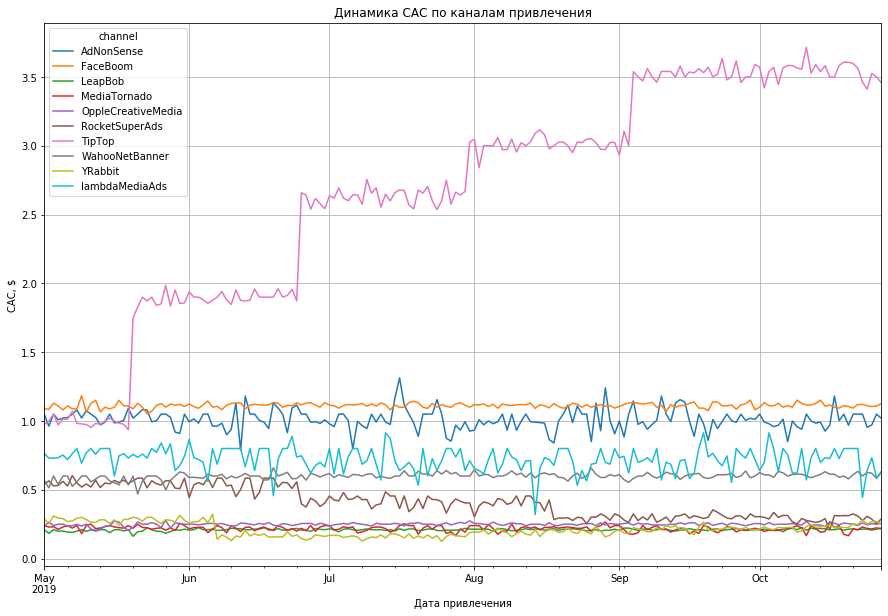

In [ ]:
profiles.query('channel != "organic"').pivot_table(index='dt', columns='channel',
                                                   values='acquisition_cost', aggfunc='mean'
                                                  ).plot(grid=True, figsize=(15, 10))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

Рассчитаем средний CAC на одного пользователя для всего проекта без учета органических пользователей, т.к. мы за них ничего не платим

In [ ]:
print('Средний CAC на одного пользователя для всего проекта {:.2f}$'. format(profiles.query('channel != "organic"')['acquisition_cost'].mean()))

Средний CAC на одного пользователя для всего проекта 1.13$


Рассчитаем средний CAC на одного пользователя для каждого источника трафика.

In [ ]:
profiles.query('channel != "organic"'
              ).groupby('channel').agg({'acquisition_cost': 'mean'}
                                      ).sort_values('acquisition_cost', ascending=False
                                                   ).rename(columns={'acquisition_cost': 'cac'})

,cac
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


#### Промежуточные выводы
- Общая сумма расходов на маркетинг: 105497.3**\$**
- Больше всего денег, 54751.3**\$**, потратили на привлечение пользователей из канала TipTop, на втором месте FaceBoom — 32445.6**\$**
- Средний CAC на одного пользователя для всего проекта 1.13**\$**
- В среднем привлечение одного пользователя из канала TipTop намного выше чем в других источниках, около 2,8**\$**
- Расходы на маркетинг канала TipTop постоянно растут во времени
- Привлечение одного пользователя, на остальных каналах ниже среднего

## 5. Оценка окупаемости рекламы для привлечения пользователей

- Данные анализируем 1-го ноября 2019 года и в нашей организации принято считать, что окупаемость должна наступать не позднее, чем через 2 недели после привлечения пользователей. Установим момент анализа — `observation_date` и горизонт анализа — `horizon_days`
- Органических пользователей исключим из анализа

In [ ]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

Проанализируем общую окупаемость рекламы.

In [ ]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions=[]
)

Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

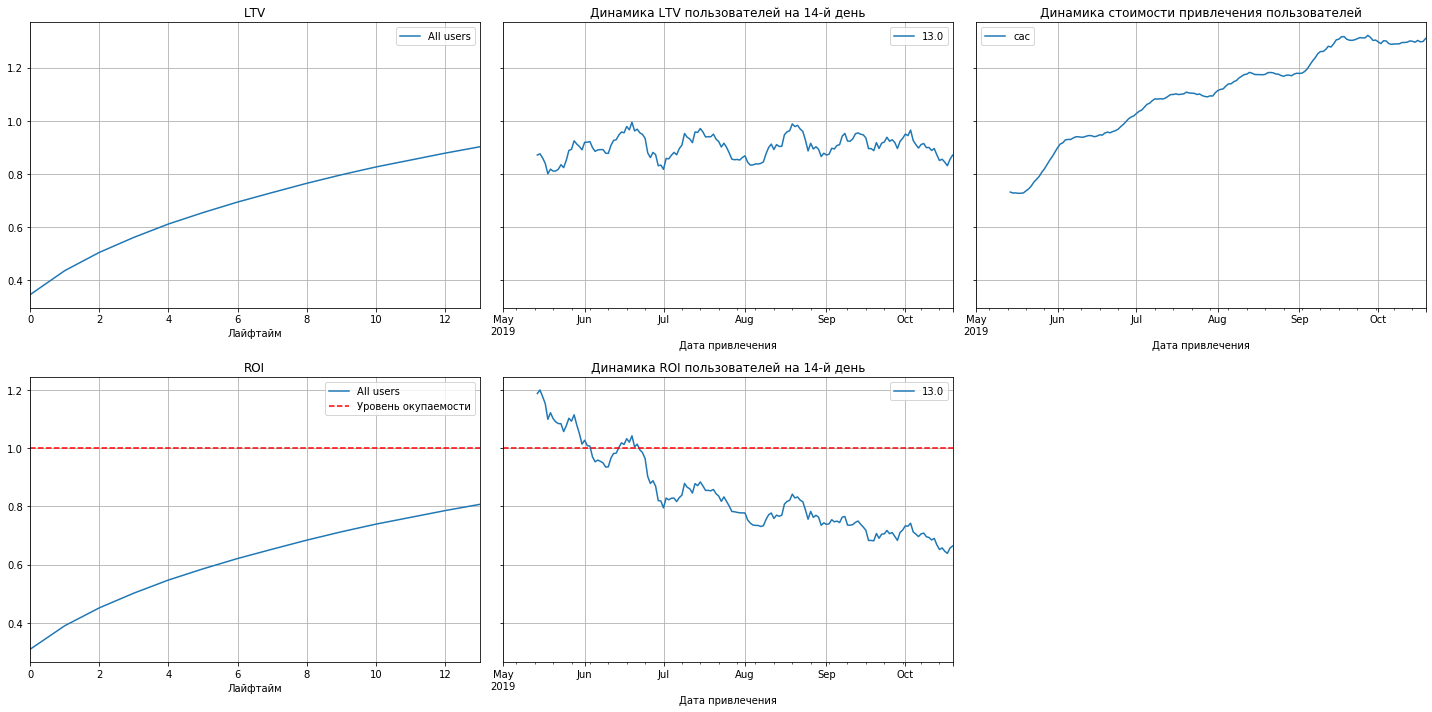

In [ ]:
warnings.filterwarnings("ignore")
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

- Реклама не окупается. ROI на 14-й день — немного выше 80%.
- CAC постоянно растет, из-за этого снижается ROI
- LTV на 14-й день стабилен

Проанализируем окупаемость рекламы с разбивкой по устройствам.

In [ ]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions=['device']
)

Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI с разбивкой по устройствам.

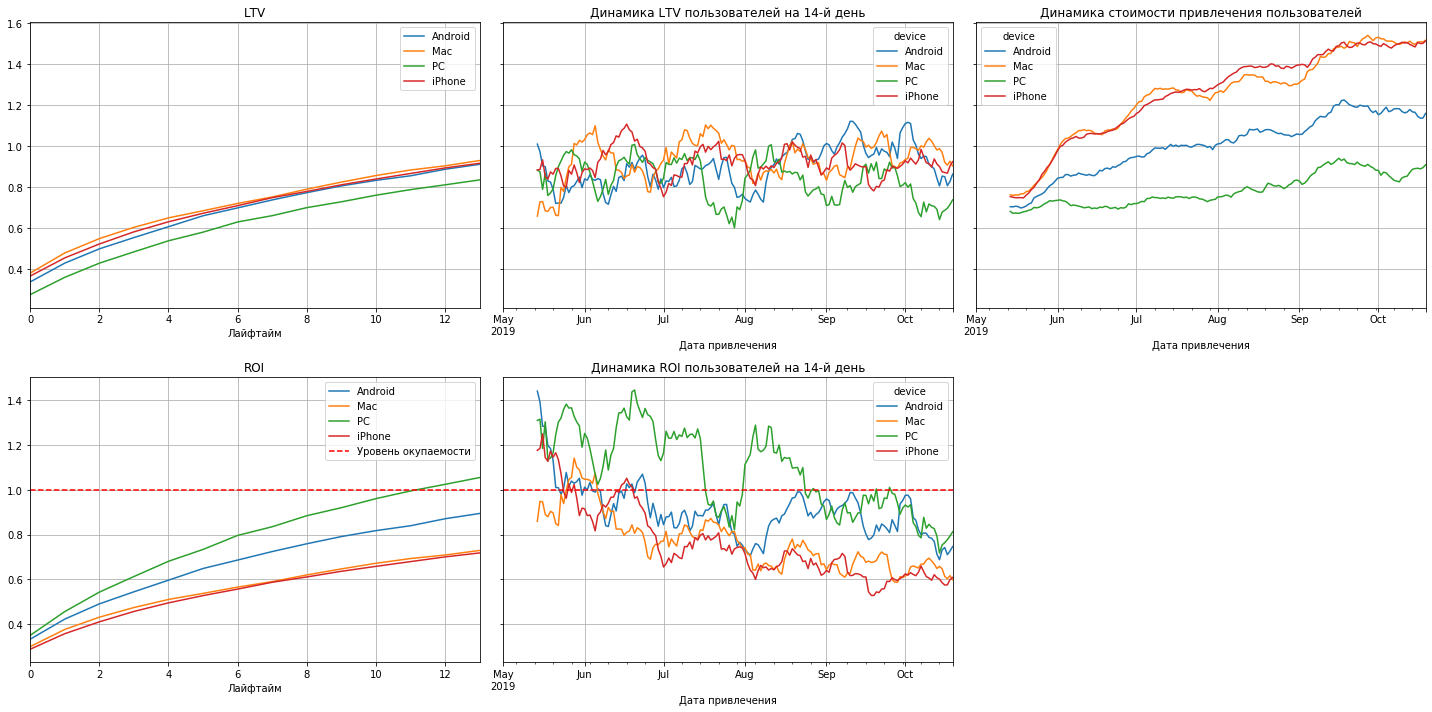

In [ ]:
warnings.filterwarnings("ignore")
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

- Реклама окупается только у пользователей PC
- CAC так же растет, но наиболее сильно растет у пользователей Mac и iPhone
- LTV на 14-й день стабилен

Проанализируем окупаемость рекламы с разбивкой по странам.

In [ ]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions=['region']
)

Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI с разбивкой по странам.

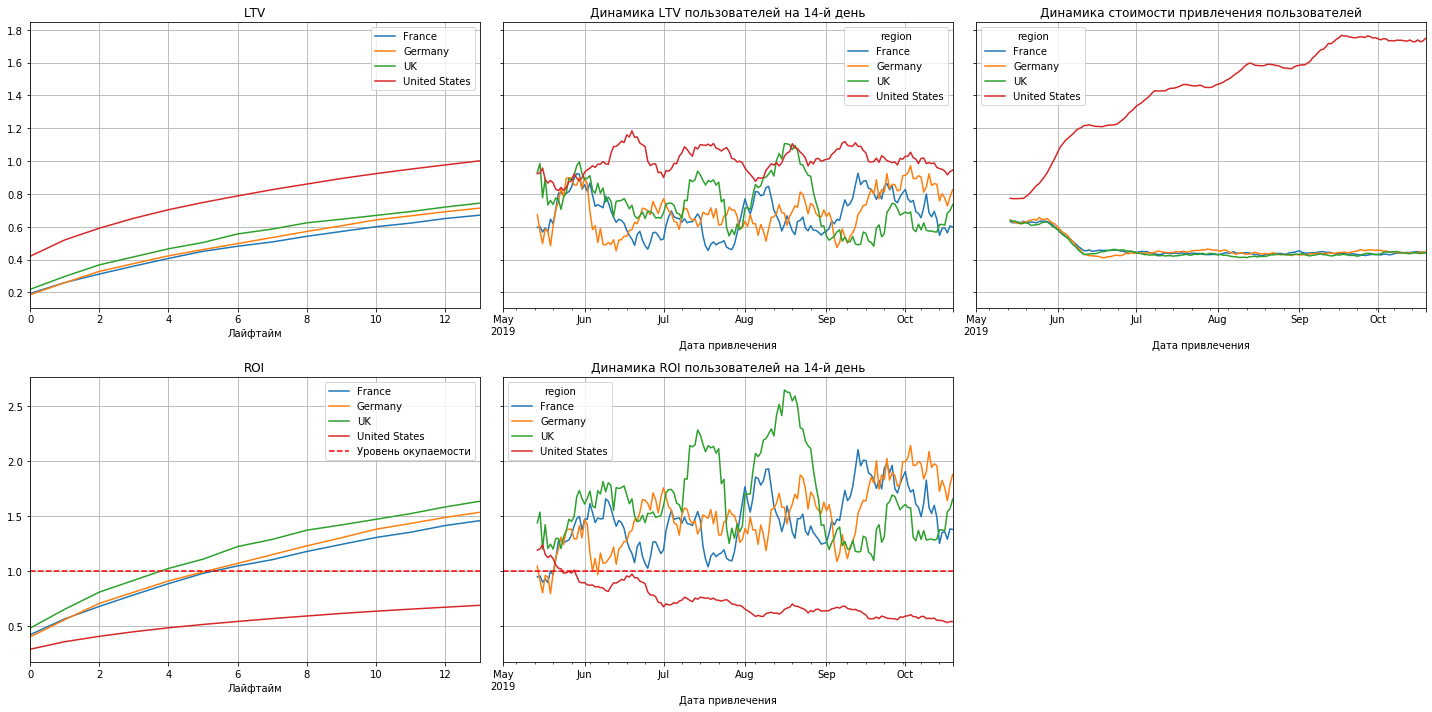

In [ ]:
warnings.filterwarnings("ignore")
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

- Реклама не окупается только в United States
- LTV в United States заметно выше чем в других странах
- LTV на 14-й день стабилен
- CAC в United States постоянно растет, а в других странах стабилен

Проанализируем окупаемость рекламы с разбивкой по рекламным каналам

In [ ]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions=['channel']
)

Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI с разбивкой по рекламным каналам

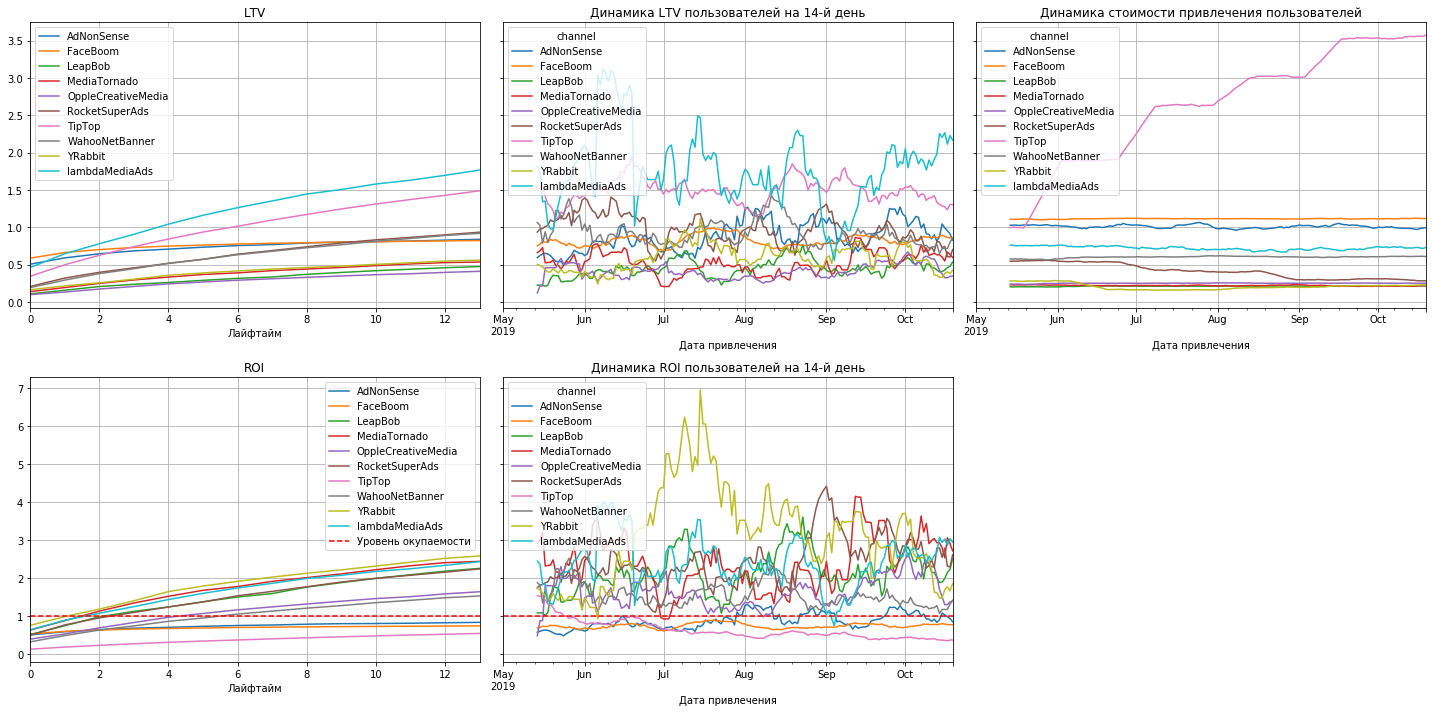

In [ ]:
warnings.filterwarnings("ignore")
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

- Не окупается реклама на каналах TipTop, FaceBoom и AdNonSense
- LTV на 14-й день стабилен
- CAC растет у канала TipTop

Изучим конверсию и удержание с разбивкой по устройствам

In [ ]:
result_raw, conversion, conversion_history = get_conversion(profiles.query('channel != "organic"'), orders, observation_date,
                                                            horizon_days, dimensions=['device'], ignore_horizon=False)

In [ ]:
result_raw, retention, retention_history = get_retention(profiles.query('channel != "organic"'), visits.query('channel != "organic"'),
                                                         observation_date, horizon_days, dimensions = ['device'], ignore_horizon = False)

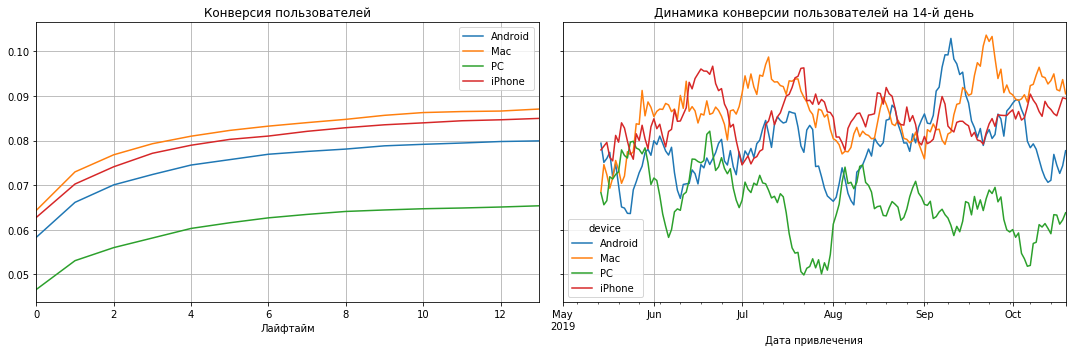

In [ ]:
plot_conversion(conversion, conversion_history, horizon_days, window=14)

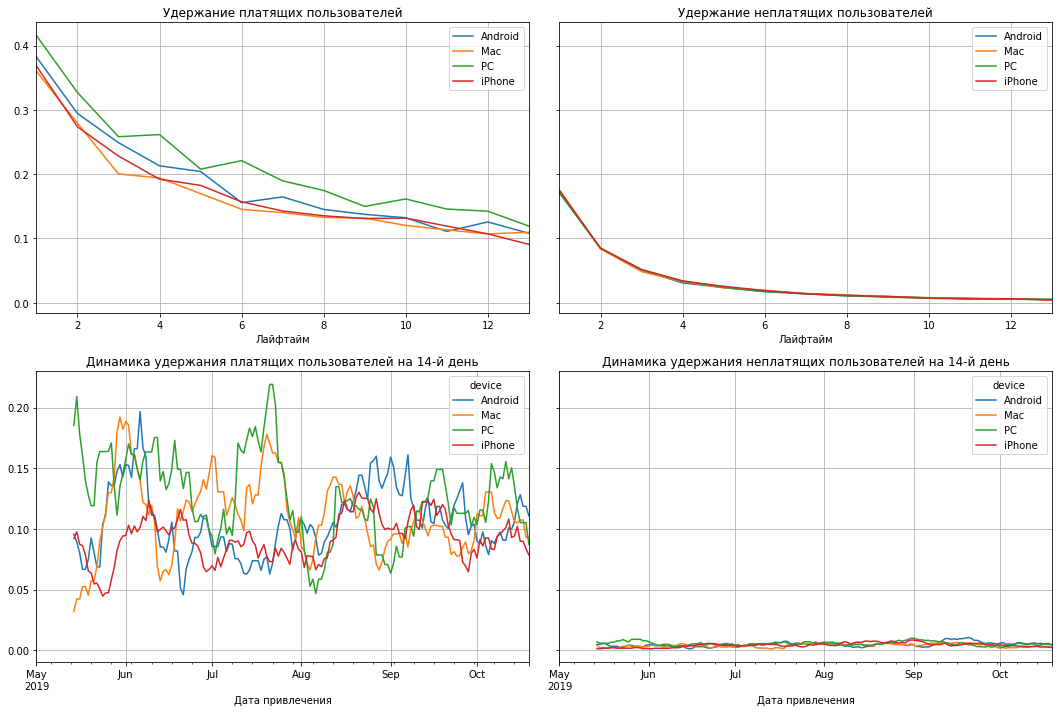

In [ ]:
warnings.filterwarnings("ignore")
plot_retention(retention, retention_history, horizon_days, window=14)

- Конверсия у пользователей Mac и iPhone нормальная и стабильная
- Удержание у пользователей всех устройств примерно одинаковое и стабильное

- 

Изучим конверсию и удержание с разбивкой по странам

In [ ]:
result_raw, conversion, conversion_history = get_conversion(profiles.query('channel != "organic"'), orders, observation_date,
                                                            horizon_days, dimensions=['region'], ignore_horizon=False)

In [ ]:
result_raw, retention, retention_history = get_retention(profiles.query('channel != "organic"'), visits.query('channel != "organic"'),
                                                         observation_date, horizon_days, dimensions = ['region'], ignore_horizon = False)

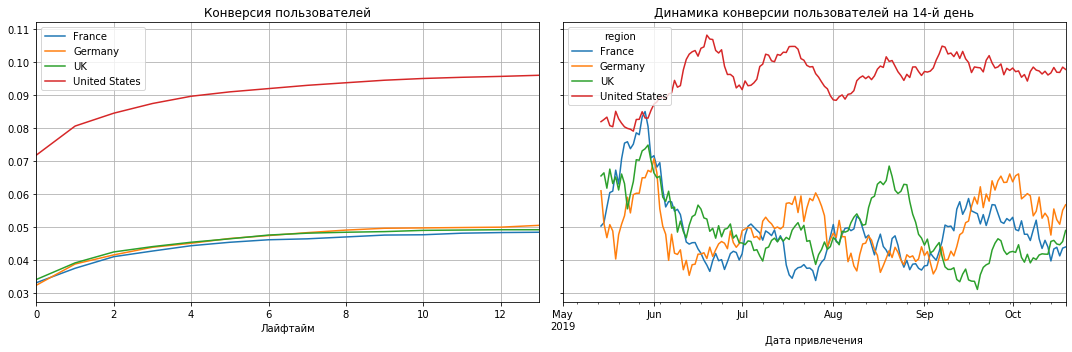

In [ ]:
plot_conversion(conversion, conversion_history, horizon_days, window=14)

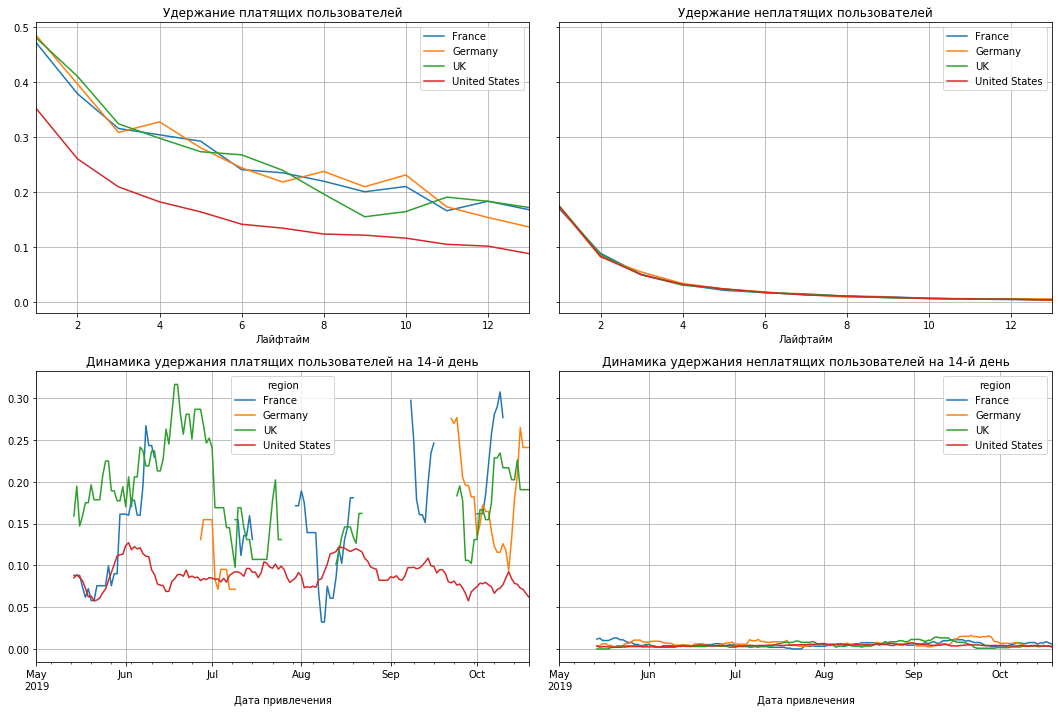

In [ ]:
warnings.filterwarnings("ignore")
plot_retention(retention, retention_history, horizon_days, window=14)

- Конверсия в United States около 9,5%, тогда как в других странах около 5%
- Удержание в United States немного ниже чем в других странах

Изучим конверсию и удержание с разбивкой по рекламным каналам

In [ ]:
result_raw, conversion, conversion_history = get_conversion(profiles.query('channel != "organic"'), orders, observation_date,
                                                            horizon_days, dimensions=['channel'], ignore_horizon=False)

In [ ]:
result_raw, retention, retention_history = get_retention(profiles.query('channel != "organic"'), visits.query('channel != "organic"'),
                                                         observation_date, horizon_days, dimensions = ['channel'], ignore_horizon = False)

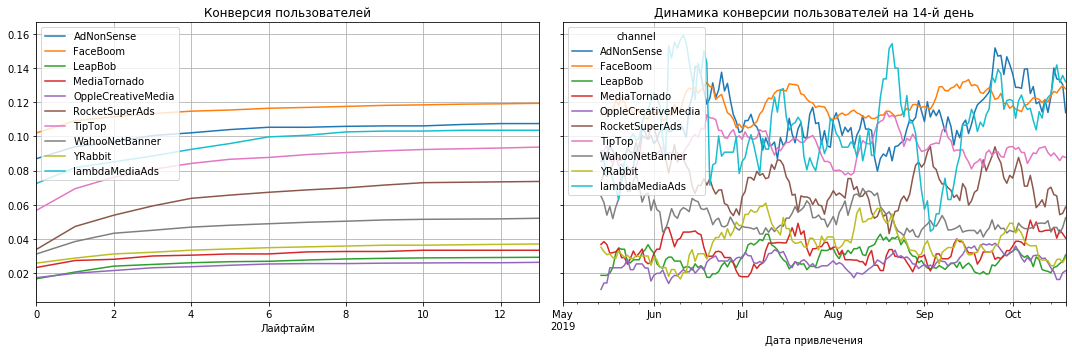

In [ ]:
plot_conversion(conversion, conversion_history, horizon_days, window=14)

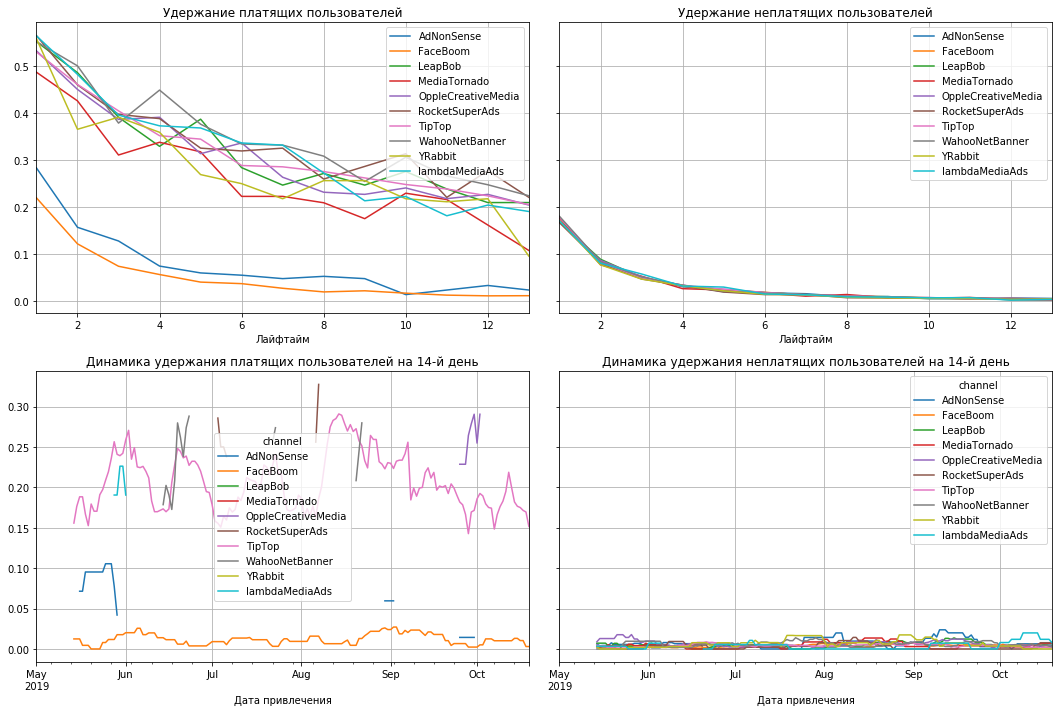

In [ ]:
warnings.filterwarnings("ignore")
plot_retention(retention, retention_history, horizon_days, window=14)

- Конверсия по каналам стабильная, канал FaceBoom лидирует, на втором месте AdNonSense, TipTop — на четвертом месте
- Удержание на каналах FaceBoom и AdNonSense ниже чем на других каналах и составляет 2% и 3% соответственно

Так как реклама не окупается только в United States, построим визуализации по пользователям из United States с разбивкой по каналам

In [ ]:
result_raw, conversion, conversion_history = get_conversion(profiles.query('channel != "organic" and region == "United States"'), orders, observation_date,
                                                            horizon_days, dimensions=['channel'], ignore_horizon=False)

In [ ]:
result_raw, retention, retention_history = get_retention(profiles.query('channel != "organic" and region == "United States"'), visits.query('channel != "organic"'),
                                                         observation_date, horizon_days, dimensions = ['channel'], ignore_horizon = False)

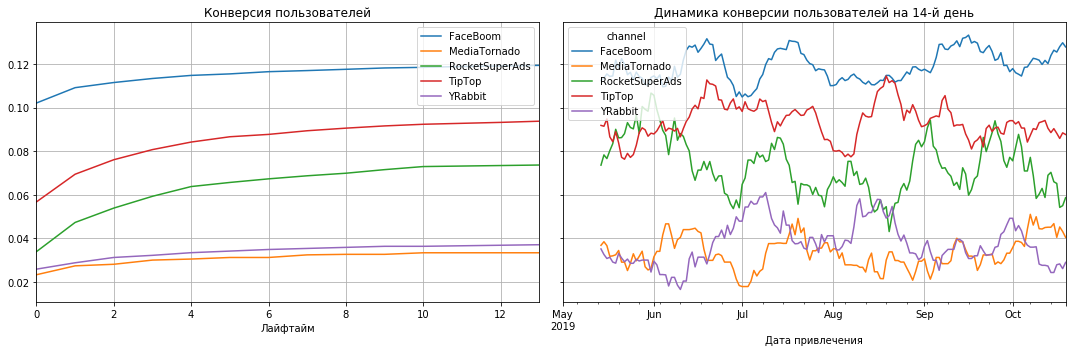

In [ ]:
plot_conversion(conversion, conversion_history, horizon_days, window=14)

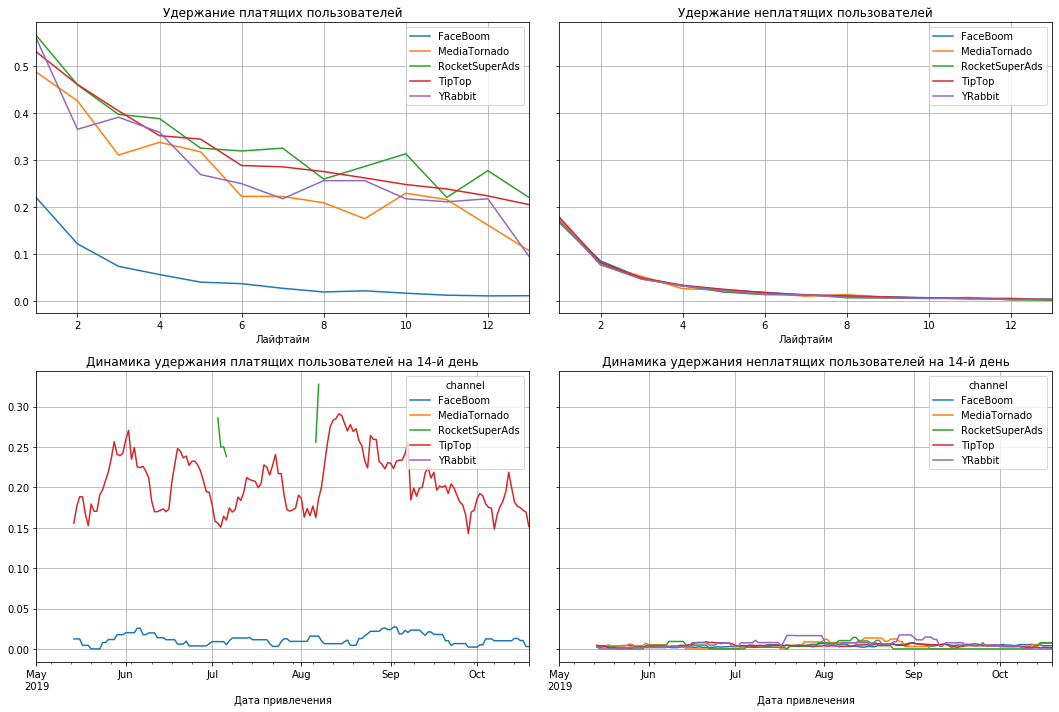

In [ ]:
warnings.filterwarnings("ignore")
plot_retention(retention, retention_history, horizon_days, window=14)

- Конверсия у каналов FaceBoom и TipTop в United States нормальная, а вот у каналов YRabbit и MediaTornado заметно ниже
- Плохо удерживаются пользователи канала FaceBoom из United States

Проанализируем окупаемость рекламы в United States с разбивкой по рекламным каналам

In [ ]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles.query('channel != "organic" and region == "United States"'), orders, observation_date, horizon_days, dimensions=['channel']
)

Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI в United States с разбивкой по рекламным каналам

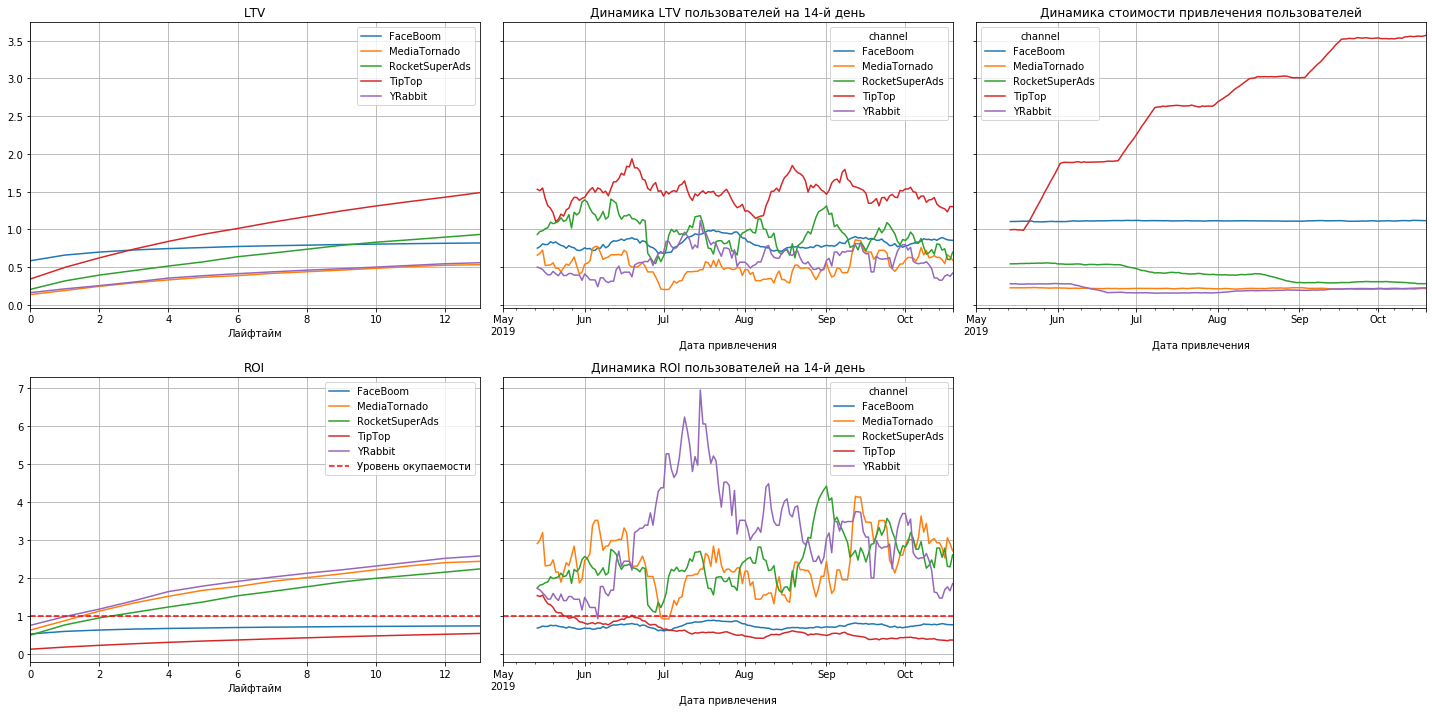

In [ ]:
warnings.filterwarnings("ignore")
plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=14)

- В United States не окупаются пользователи каналов FaceBoom и TipTop
- В United States CAC растет у канала TipTop, за весь период он вырос с 1**\$** до 3,6**\$**

#### Промежуточный вывод
- При оценке общей окупаемости рекламы было выявлено, что реклама не окупается, ROI на 14-й день немного выше 80%. LTV на 14-й день стабилен, значит дело не в нем. Стоимость привлечения пользователей (CAC) постоянно растет, из-за этого ROI на 14-й день постоянно снижается.
- При оценке окупаемости рекламы с разбивкой по устройствам, было обнаружено, что реклама окупается только у пользователей PC, у пользователей Android, Mac и iPhone реклама не окупается. LTV на 14-й день на всех устройствах стабилен. CAC растет на всех устройствах, но наиболее сильно растет у пользователей Mac и iPhone.
- При оценке окупаемости рекламы с разбивкой по странам, было обнаружено, что  реклама не окупается только в United States, хотя LTV в United States выше чем в других странах. В Germany, UK и France реклама окупается на примерно на 4-6-й день. CAC в United States постоянно растет, а в других странах стабилен. ROI на 14-й день в United States постоянно снижается.
- При оценке окупаемости рекламы с разбивкой по каналам, было выявлено, что реклама на каналах TipTop, FaceBoom и AdNonSense не окупается. LTV на 14-й день стабилен на всех каналах. CAC растет только у канала TipTop.
- Конверсия на устройствах Mac, iPhone и Android нормальная и стабильная. На PC конверсия несколько ниже. Удержание пользователей у всех устройств примерно одинаковое и стабильное, значит о технических ошибках скорее всего речь не идет.
- Конверсия в United States около 9,5%, тогда как в Germany, UK и France около 5%. Удержание в United States немного ниже чем в других странах.
- Конверсия по каналам стабильная, канал FaceBoom лидирует, на втором месте AdNonSense, TipTop — на четвертом месте. Удержание на каналах FaceBoom и AdNonSense ниже чем на других каналах и составляет 2% и 3% соответственно.
- При анализе окупаемости рекламы в United States, с разбивкой по каналам, было обнаружено, что В United States не окупаются пользователи каналов FaceBoom и TipTop. В United States CAC растет у канала TipTop, за весь период он вырос с 1**\$** до 3,6**\$**
- Конверсия у каналов FaceBoom и TipTop в United States нормальная, а вот у каналов YRabbit и MediaTornado заметно ниже. Плохо удерживаются пользователи канала FaceBoom из United States.

## 6. Выводы

#### Исследовательский анализ данных
- Минимальная дата привлечения пользователей 2019-05-01
- Максимальная дата привлечения пользователей 2019-10-27
- Самая большая доля (6.90%) и самое большое количество (6902) платящих пользователей из United States, в остальных странах на порядок меньше
- Самая большая доля платящих пользователей (6.36%) среди пользователей устройства Mac, однако поколичеству (3382) лидирует iPhone
- Самая большая доля (12.20%) и самое большое количество (3557) платящих пользователей у канала FaceBoom, на втором месте по количеству (1878) TipTop

#### Маркетинг
- Общая сумма расходов на маркетинг: 105497.3**\$**
- Больше всего денег, 54751.3**\$**, потратили на привлечение пользователей из канала TipTop, на втором месте FaceBoom — 32445.6**\$**
- Средний CAC на одного пользователя для всего проекта 1.13**\$**
- В среднем привлечение одного пользователя из канала TipTop намного выше чем в других источниках, около 2,8**\$**
- Расходы на маркетинг канала TipTop постоянно растут во времени с 1**\$** до 3,6**\$**
- Привлечение одного пользователя, на остальных каналах ниже среднего

#### Оценка окупаемости рекламы
- При оценке общей окупаемости рекламы было выявлено, что реклама не окупается, ROI на 14-й день немного выше 80\%. LTV на 14-й день стабилен, значит дело не в нем. Стоимость привлечения пользователей (CAC) постоянно растет, из-за этого ROI на 14-й день постоянно снижается.
- При оценке окупаемости рекламы с разбивкой по устройствам, было обнаружено, что реклама окупается только у пользователей PC, у пользователей Android, Mac и iPhone реклама не окупается. LTV на 14-й день на всех устройствах стабилен. CAC растет на всех устройствах, но наиболее сильно растет у пользователей Mac и iPhone.
- При оценке окупаемости рекламы с разбивкой по странам, было обнаружено, что  реклама не окупается только в United States, хотя LTV в United States выше чем в других странах. В Germany, UK и France реклама окупается на примерно на 4-6-й день. CAC в United States постоянно растет, а в других странах стабилен. ROI на 14-й день в United States постоянно снижается.
- При оценке окупаемости рекламы с разбивкой по каналам, было выявлено, что реклама на каналах TipTop, FaceBoom и AdNonSense не окупается. LTV на 14-й день стабилен на всех каналах. CAC растет только у канала TipTop.
- Конверсия на устройствах Mac, iPhone и Android нормальная и стабильная. На PC конверсия несколько ниже. Удержание пользователей у всех устройств примерно одинаковое и стабильное, значит о технических ошибках скорее всего речь не идет.
- Конверсия в United States около 9,5\%, тогда как в Germany, UK и France около 5\%. Удержание в United States немного ниже чем в других странах.
- Конверсия по каналам стабильная, канал FaceBoom лидирует, на втором месте AdNonSense, TipTop — на четвертом месте. Удержание на каналах FaceBoom и AdNonSense ниже чем на других каналах и составляет 2\% и 3\% соответственно.
- При анализе окупаемости рекламы в United States, с разбивкой по каналам, было обнаружено, что В United States не окупаются пользователи каналов FaceBoom и TipTop. В United States CAC растет у канала TipTop, за весь период он вырос с 1**\$** до 3,6**\$**
- Конверсия у каналов FaceBoom и TipTop в United States нормальная, а вот у каналов YRabbit и MediaTornado заметно ниже. Плохо удерживаются пользователи канала FaceBoom из United States.

#### Общий вывод
- Реклама не окупается только в United States, т. к. там самая большая доля и самое большое количество платящих пользователей, это повлияло на то что реклама в общем и целом не окупается.
- Основная проблема в том, что растет стоимость привлечения пользователей на канале TipTop, по количеству пользователей он на втором месте, из-за этого реклама не окупается в общем и целом.
- Так же не окупается реклама на каналах FaceBoom и AdNonSense, из-за того что на них низкое удержание пользователей, тем более, что канал FaceBoom на первом месте по количеству пользователей.
- Конверсия в United States выше чем в европейских странах, а удержание ниже.
- Низкая конверсия на каналах YRabbit и MediaTornado.

#### Рекомендации для отдела маркетинга
- Снизить стоимость привлечения пользователей на канале TipTop.
- Наити причины низкого удержания на каналах FaceBoom и AdNonSense.
- Наити причины низкого удержания в United States.
- Наити причины низкой конверсии в европейских странах.
- Наити причины низкой конверсии на каналах YRabbit и MediaTornado.